# Mergings Loops

**Important** this not yet appears in the paper but it is important!

## Imports

In [1]:
import sys
sys.path.append("../../src")
%reload_ext autoreload
%autoreload 2
from helpers import graph
from path_invariants import *
from math import sqrt

## Loop recovery from a merge

A desirable property of mergings is that path and loops can be recovered. If $A$ is a path, $C$ merging between $A$ and any trace $B$, **what conditions do we need in the merging to recover $A$?**. This is the same that proves that the successor graph of $C$ has an f-clique $V_f$ such that $G^S_C \cap V_f$ verifies the path condition for $A$

$G^S_C \cap V_f = G^S_{A}$

*(Transfer to the paper)* We alse saw, somewhere, that the upper-layer of a loop is a path. Then, it makes sense to search cliques in f-layers and verify if they are a path. For this the f-clique set of a graph are the cliques set of its f-layer.

Here we use the **lemma** that a 2-loop of a merge is a full-merge (see [Merging](Mergings.ipynb)), and will develop a procedure to extract the paths by merely duplicating C and then take $r/2$

## Example

As we saw in [Merging](Mergings.ipynb), $C=xAy$ is a merging (not full) of $A=pq$ and $B=xy$. But, now lets loop $A$. 

In [2]:
A  = "pq"
B  = "xy"
C  = "x" + A*4 + "y"
C2 = C+C
sgC     = successor_graph(C)
sgC2    = successor_graph(C2)

'C=xpqpqpqpqy'

'C2=xpqpqpqpqyxpqpqpqpqy'

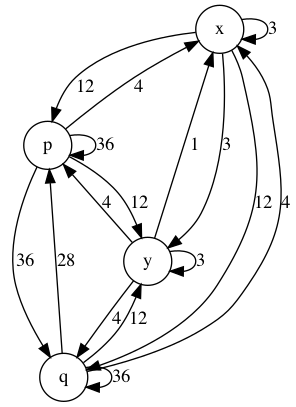

In [3]:
display("C=%s" % C)
display("C2=%s" % C2)
graph( sgC2 )

Here we see that duplicate the merge is a full merge

In [4]:
# Is C a full merge? (all True)
[ ( (a,b), (b,a), (a, b) in sgC.edges, (b, a) in sgC.edges ) for a in A for b in B]

[(('p', 'x'), ('x', 'p'), False, True),
 (('p', 'y'), ('y', 'p'), True, False),
 (('q', 'x'), ('x', 'q'), False, True),
 (('q', 'y'), ('y', 'q'), True, False)]

A valid question is: does the subgraph $G^S_C \cap A$ where $C=(x) rA (y)$ verifies the loop condition?

In [5]:
H = sgC2.copy()
for node in set(H.nodes).difference( set(["p", "q"]) ):
    H.remove_node(node)

loop_condition(sgC)

(False, 0, 0)

We have shown one example where the loop cannot be extracted from a merge. But, if we duplicate the trace $C$ we obtain a full merge:

In [6]:
# Is C2 a full merge? (all True)
[ ( (a,b), (b,a), (a, b) in sgC2.edges, (b, a) in sgC2.edges ) for a in A for b in B]

[(('p', 'x'), ('x', 'p'), True, True),
 (('p', 'y'), ('y', 'p'), True, True),
 (('q', 'x'), ('x', 'q'), True, True),
 (('q', 'y'), ('y', 'q'), True, True)]

We are searching for the behavior of $A=pq$ in the successor graph. Look at f-layers in $C2$, $f=36, 28$, they verifies the loop condition for a loop of 8 $pq$.

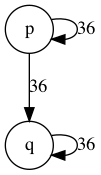

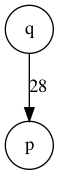

8.0

In [7]:
graph( f_layer(36, sgC2) )
graph( f_layer(28, sgC2) )
sqrt(36 + 28)

We take the subgraph $G^S_{C2} \cap V_q={p, q}$

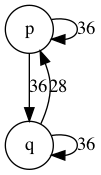

In [8]:
# For {p,q}
H = sgC2.copy()
for node in set(H.nodes).difference( set(["p", "q"]) ):
    H.remove_node(node)
    
graph(H)

In [9]:
is_loop, w1, w2 = loop_condition(H)
is_loop, w1, w2 

(True, 28, 36)

In [10]:
path = [ u for u, InDeg  in  sorted( H.in_degree() , key=lambda u: u[1], reverse=False)]
path, sqrt(w1+w2)/2

(['p', 'q'], 4.0)

Then in $C$ there where 4 $pq$ as we already knew.

## General procedure

Given a trace $C$, we search f-cliques in the successor graph of $C_2=CC$:

In [11]:
weights = set( [sgC2[u][v]["weight"] for u, v in sgC2.edges() ] )
for f in weights:
    display( (f, list( cliques( f_layer(f, sgC2).to_undirected() )) ) )

(1, [['y', 'x']])

(3, [['y', 'x']])

(4, [['y', 'q'], ['y', 'p'], ['x', 'q'], ['x', 'p']])

(36, [['q', 'p']])

(12, [['q', 'y'], ['q', 'x'], ['p', 'y'], ['p', 'x']])

(28, [['q', 'p']])

Then, we need to take the set of unique cliques

In [12]:
unique_cliques = set()
for f in weights:
    for clique in cliques( f_layer(f, sgC2).to_undirected() ):
        unique_cliques.add(tuple( sorted(clique)))
unique_cliques

{('p', 'q'), ('p', 'x'), ('p', 'y'), ('q', 'x'), ('q', 'y'), ('x', 'y')}

For each clique $V_q$, we build the graph restricted to those vertices $G^S_{C2} \cap V_q$ and verify the loop condition

In [13]:
paths_found = []

for Vq in unique_cliques:
    H = sgC2.copy()
    for node in set(H.nodes).difference( set(Vq) ):
        H.remove_node(node)
    display( "searching in %s" % H.nodes )
    is_loop, w1, w2 = loop_condition(H)
    if is_loop:
        path = [ u for u, InDeg  in  sorted( H.in_degree() , key=lambda u: u[1], reverse=False)]
        r    = sqrt(w1+w2)/2
        paths_found.append( (r, path) )
        
display(paths_found)

"searching in ['x', 'p']"

"searching in ['x', 'y']"

"searching in ['p', 'q']"

"searching in ['p', 'y']"

"searching in ['q', 'y']"

"searching in ['x', 'q']"

[(1.0, ['x', 'y']), (4.0, ['p', 'q'])]

We obtained, the paths $A$ and $B$  with their respective repetitions.

The function paths_from_trace implements the ideas above. 

In [14]:
paths_from_trace(C)

[(1.0, ['x', 'y']), (4.0, ['p', 'q'])]

## All pairs property

With the method above we have describe the all pairs trace. Any repetition of single symbols are not a pair, then they are discarded. And the remaing trace are either a single long path, or loops.

In [23]:
A = "PQR"
B = "LMNO"
C = "ab.++..+++cd." + A*9 + B + A + B + "z.x....++..y."
paths_from_trace(C)

[(10.0, ['P', 'Q', 'R']),
 (2.0, ['L', 'M', 'N', 'O']),
 (1.0, ['a', 'b', 'c', 'd', 'z', 'x', 'y'])]

## Equivalence with multiple paths combination

Note that with this method we can verify the multi path graph equivalence (strong claim in the paper) that corresponds to same discovered paths

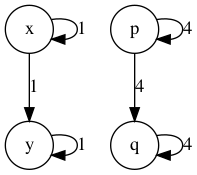

In [16]:
A ="xy"; sgA = successor_graph(A)
B="pq" ; sgB = successor_graph(B)
multipathG = add_graphs( sgA, sgB, sgB, sgB, sgB)

graph(multipathG)

In [17]:
paths_in_components( multipathG )

[(1, ['x', 'y']), (4, ['p', 'q'])]

In [18]:
C = A + B*4
paths_from_trace(C)

[(1.0, ['x', 'y']), (4.0, ['p', 'q'])]

### DISCARD this section

(kept only for personal reference) The goal now is to TRANSFORM C in a multi path graph with loop only information, but keeping any suprious pairs if any. This will be useful when combining several traces. We will remove the edges in the lower-layer and all inter-successors!!. Remember that  single paths don't have lower-layers.

In [19]:
sgC = successor_graph(C)
# graph(sgC)
C

'xypqpqpqpq'

In [20]:
sgC_equivalent = sgC.copy()
for r, path in paths_from_trace(C):
    if r>1:
        for u, v in zip( path[:-1], path[1:]) :
            print ("removing lower-layer edges %s -> %s" % (u, v) )
            sgC_equivalent.remove_edge(v, u)
        
        print("removing inter-successors")
        print( sgC_equivalent.edges )

# graph(sgC_equivalent)

removing lower-layer edges p -> q
removing inter-successors
[('x', 'x'), ('x', 'y'), ('x', 'p'), ('x', 'q'), ('y', 'y'), ('y', 'p'), ('y', 'q'), ('p', 'p'), ('p', 'q'), ('q', 'q')]


In [37]:
paths_from_trace("pqxypxyqpqxy")

[(3.0, ['p', 'q']), (3.0, ['p', 'x', 'y'])]

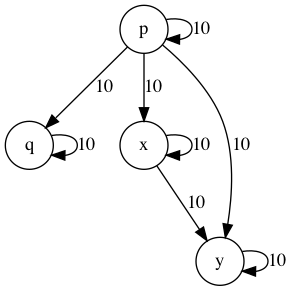

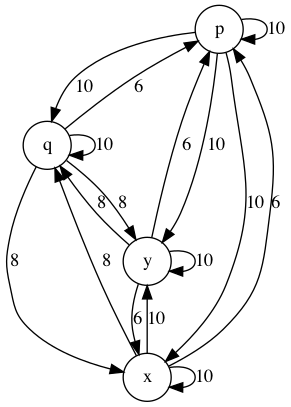

In [31]:
ugly = successor_graph("pqxypxyq"*2)
graph( f_layer(10, ugly) )
graph( ugly )
